# Compare Gait Events from Shank-Worn IMU to Optical Motion Capture Data

**Author:** Robbin Romijnders  
**Last Update:** Mon 18 Oct 2021

This notebook demonstrates how we get from the raw optical motion capture (OMC) data to detecting instants of initial foot contact (ICs) and final contacts. Accurate detection of gait events is essential for any clinical gait analysis (Rueterbories *et al*., 2010). In healthy gait, these events are mostly marked by heel strike and toe off, however in pathological gait this may not be the case (Bruening *et al*., 2014). Therefore we prefer referring to the events as IC and FC.  
In literature, a plethora of methods have been reported for the automatic detection of gait events from OMC data. In Hendershot *et al*. (2016) and in Ulrich *et al*. (2019) a selection of methods were compared, and both studies suggested to use the methods from O'Connor *et al*. (2007) for IC detection and the method from Zeni Jr *et al*. (2008) for FC detection. For some participants, however, O'Connor's method did not work, and thus we opted to implement Pijnappels *et al*. (2001) as well. In the latter, the same principles are followed as in O'Connor *et al*. (2007), however the heel and toe marker position data are not combined into a virtual foot center trajectory. 

## 0. Prerequisites

Load necessary Python libraries and define the directory where the data can be found.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lib.utils import _load_file
from lib.preprocessing import _predict_missing_markers, _butter_lowpass, _align_trajectories_with_walking_direction, _get_start_end_index, _get_data_from_marker
from lib.analysis import _get_gait_events_from_OMC, _extract_temporal_gait_params, _get_gait_evens_from_IMU
import os
from scipy.signal import find_peaks

In [2]:
# Set data directory
PARENT_FOLDER = "/mnt/neurogeriatrics_data/Keep Control/Data/lab dataset"  # on Linux
# PARENT_FOLDER = "Z:\\Keep Control\\Data\\lab dataset"  # on Windows

# Get a list of participant ids
participant_ids = [folder_name for folder_name in os.listdir(PARENT_FOLDER) if folder_name.startswith("pp")]
print(f"Number of participants: {len(participant_ids)}")

Number of participants: 136


## 1. Get the data

In [3]:
# Trial to investigate
trial_name = "walk_preferred"

# Loop over the participants
for (ix_participant, participant_id) in enumerate(participant_ids[25:26]):

    # Get a list of OMC data files
    omc_filenames = [file_name for file_name in os.listdir(os.path.join(PARENT_FOLDER, participant_id, "optical")) if file_name.endswith(".mat")]

    # Select only the file corresponding to the trial of interest
    ix_omc_filename = [ix for ix in range(len(omc_filenames)) if ("walk_preferred" in omc_filenames[ix])]
    if len(ix_omc_filename) > 0:
        ix_omc_filename = ix_omc_filename[0]
        omc_filename = omc_filenames[ix_omc_filename]

        # Check if there is an equivalent IMU file
        if os.path.isfile(os.path.join(PARENT_FOLDER, participant_id, "imu", omc_filename.replace("omc_", "imu_"))):
            imu_filename = omc_filename.replace("omc_", "imu_")

            # Load the data
            omc_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, "optical", omc_filename))
            fs_omc = omc_data["fs"]
            imu_data = _load_file(os.path.join(PARENT_FOLDER, participant_id, "imu", imu_filename))
            fs_imu = imu_data["fs"]
print(f"Participant: {participant_id}")

Participant: pp029


## 2. Preprocess the data
Get the data sampling frequency, and explore the number of time steps (frames) and the number of markers used. Then, account for any gaps in the marker data by filling gaps based on marker intercorrelations. Low-pass filter the marker data to reduce the effects of high-frequency noise. Finally, align the marker trajectories with the main direction of walking.

In [4]:
# Get data shape
n_time_steps, n_dimensions, n_markers = omc_data["pos"][:,:-1,:].shape
print(f"# time steps: {n_time_steps}")
print(f"# markers: {n_markers}")

# time steps: 1951
# markers: 51


In [5]:
# Check if marker data is available for all relevant markers
l_heel_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='l_heel')
r_heel_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='r_heel')
l_toe_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='l_toe')
r_toe_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='r_toe')
l_psis_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='l_psis')
r_psis_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='r_psis')
l_asis_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='l_asis')
r_asis_pos = _get_data_from_marker(omc_data["pos"][:,:3,:], omc_data["marker_location"], marker='r_asis')
if (l_heel_pos is None) or (l_toe_pos is None) or (l_psis_pos is None) or (l_asis_pos is None) or (r_heel_pos is None) or (r_toe_pos is None) or (r_psis_pos is None) or (r_asis_pos is None):
    print(f"Missing some relevant marker data!")
pelvis_pos = ( l_psis_pos + l_asis_pos + r_psis_pos + r_asis_pos ) / 4

In [6]:
# Reshape data to (n_time_steps, n_dimensions * n_markers)
raw_data = np.reshape(omc_data["pos"][:,:3,:], (n_time_steps, n_dimensions*n_markers), order="F")

# Fill gaps in marker data
filled_data = _predict_missing_markers(raw_data)

# Low-pass filter, and reshape back to original shape
filtered_data = _butter_lowpass(filled_data, fs_omc)
filtered_data = np.reshape(filtered_data, (n_time_steps, n_dimensions, n_markers), order="F")

# Align data with main direction of walking
aligned_data = _align_trajectories_with_walking_direction(filtered_data, omc_data["marker_location"])

# Get start and end index
ix_start, ix_end = _get_start_end_index(aligned_data, omc_data["marker_location"])

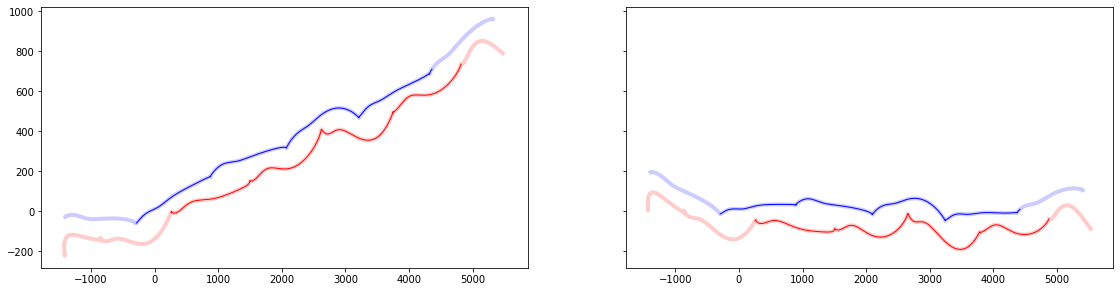

In [7]:
# Visualize
fig, axs = plt.subplots(1, 2, figsize=(19.2, 4.8), sharex=True, sharey=True)
axs[0].plot(filtered_data[:,0,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], filtered_data[:,1,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], '-', c=(0, 0, 1, 0.2), lw=4)
axs[0].plot(filtered_data[ix_start:ix_end,0,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], filtered_data[ix_start:ix_end,1,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], '-', c=(0, 0, 1, 1), lw=1)
axs[0].plot(filtered_data[:,0,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], filtered_data[:,1,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], '-', c=(1, 0, 0, 0.2), lw=4)
axs[0].plot(filtered_data[ix_start:ix_end,0,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], filtered_data[ix_start:ix_end,1,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], '-', c=(1, 0, 0, 1), lw=1)
axs[1].plot(aligned_data[:,0,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], aligned_data[:,1,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], '-', c=(0, 0, 1, 0.2), lw=4)
axs[1].plot(aligned_data[ix_start:ix_end,0,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], aligned_data[ix_start:ix_end,1,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], '-', c=(0, 0, 1, 1), lw=1)
axs[1].plot(aligned_data[:,0,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], aligned_data[:,1,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], '-', c=(1, 0, 0, 0.2), lw=4)
axs[1].plot(aligned_data[ix_start:ix_end,0,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], aligned_data[ix_start:ix_end,1,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], '-', c=(1, 0, 0, 1), lw=1)
plt.show()

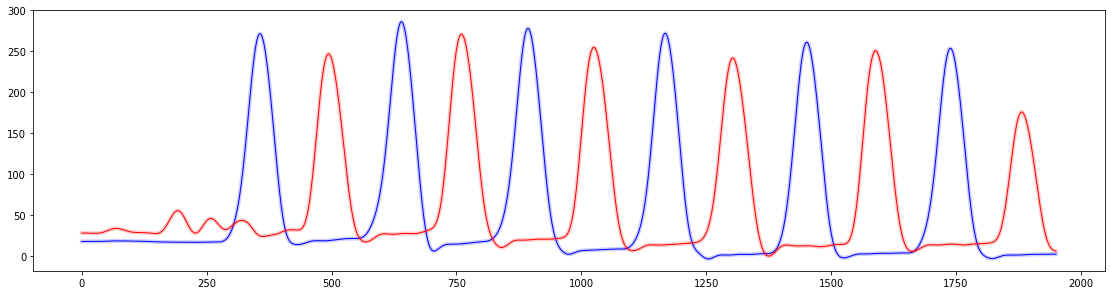

In [8]:
# Visualize
fig, ax = plt.subplots(1, 1, figsize=(19.2, 4.8))
ax.plot(filtered_data[:,2,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], '-', c=(0, 0, 1, 0.2), lw=4)
ax.plot(aligned_data[:,2,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], '-', c=(0, 0, 1, 1), lw=1)
ax.plot(filtered_data[:,2,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], '-', c=(1, 0, 0, 0.2), lw=4)
ax.plot(aligned_data[:,2,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], '-', c=(1, 0, 0, 1), lw=1)
plt.show()

## 3. Process the data - detect instants of gait events
We continue to find the exact instants in times when gait events, i.e., initial contacts (ICs) and final contacts (FCs), occur. ICs are detected based on local minima in the vertical velcoity of a virtual foot center marker (O'Connor *et al*., 2007). The virtual foot center is defined as the midpoint of the heel and toe marker. FCs are based on local minima in the toe marker position relative to the pelvis position (Zeni Jr *et al*., 2008). 

In [10]:
# Detect gait events
l_ix_IC, _, r_ix_IC, _ = _get_gait_events_from_OMC(aligned_data, fs_omc, omc_data["marker_location"], "OConnor")
_, l_ix_FC, _, r_ix_FC = _get_gait_events_from_OMC(aligned_data, fs_omc, omc_data["marker_location"], method="ZeniJr")
l_ix_IC_2, _, r_ix_IC_2, _ = _get_gait_events_from_OMC(aligned_data, fs_omc, omc_data["marker_location"], "Pijnappels")

In [11]:
left_ix_IC = l_ix_IC[np.logical_and(l_ix_IC >= ix_start, l_ix_IC <= ix_end)]
left_ix_FC = l_ix_FC[np.logical_and(l_ix_FC >= ix_start, l_ix_FC <= ix_end)]
right_ix_IC = r_ix_IC[np.logical_and(r_ix_IC >= ix_start, r_ix_IC <= ix_end)]
right_ix_FC = r_ix_FC[np.logical_and(r_ix_FC >= ix_start, r_ix_FC <= ix_end)]
left_ix_IC_2 = l_ix_IC_2[np.logical_and(l_ix_IC_2 >= ix_start, l_ix_IC_2 <= ix_end)]
right_ix_IC_2 = r_ix_IC_2[np.logical_and(r_ix_IC_2 >= ix_start, r_ix_IC_2 <= ix_end)]

In [12]:
# Get relevant markers
l_psis_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="l_psis")[:,0]], axis=-1)
r_psis_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="r_psis")[:,0]], axis=-1)
l_asis_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="l_asis")[:,0]], axis=-1)
r_asis_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="r_asis")[:,0]], axis=-1)
pelvis_pos = ( l_psis_pos + r_psis_pos + l_asis_pos + r_asis_pos ) / 4
l_heel_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="l_heel")[:,0]], axis=-1)
r_heel_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="r_heel")[:,0]], axis=-1)
l_toe_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="l_toe")[:,0]], axis=-1)
r_toe_pos = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="r_toe")[:,0]], axis=-1)
l_mid_foot_pos = ( l_heel_pos + l_toe_pos ) / 2
r_mid_foot_pos = ( r_heel_pos + r_toe_pos ) / 2
start_1 = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="start_1")[:,0]], axis=-1)
start_2 = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="start_2")[:,0]], axis=-1)
end_1 = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="end_1")[:,0]], axis=-1)
end_2 = np.squeeze(aligned_data[:,:,np.argwhere(omc_data["marker_location"]=="end_2")[:,0]], axis=-1)

In [13]:
# Compute velocity signals for the virtual foot centre marker
l_mid_foot_vel = l_mid_foot_pos.copy()
l_mid_foot_vel[1:,:] = ( l_mid_foot_pos[1:,:] - l_mid_foot_pos[:-1,:] ) / (1/fs_omc)
l_mid_foot_vel[0,:] = l_mid_foot_vel[1,:]
r_mid_foot_vel = r_mid_foot_pos.copy()
r_mid_foot_vel[1:,:] = ( r_mid_foot_pos[1:,:] - r_mid_foot_pos[:-1,:] ) / (1/fs_omc)
r_mid_foot_vel[0,:] = r_mid_foot_vel[1,:]

# Compute the velocity signals for the heel and toe markers (right)
r_heel_vel = r_heel_pos.copy()
r_heel_vel[1:,:] = ( r_heel_pos[1:,:] - r_heel_pos[:-1,:] ) / (1/fs_omc)
r_heel_vel[0,:] = r_heel_vel[1,:]
r_toe_vel = r_toe_pos.copy()
r_toe_vel[1:,:] = ( r_toe_pos[1:,:] - r_toe_pos[:-1,:] ) / (1/fs_omc)
r_toe_vel[0,:] = r_toe_vel[1,:]

# Compute acceleration signals for the foot markers
r_mid_foot_acc = r_mid_foot_vel.copy()
r_mid_foot_acc[1:,:] = ( r_mid_foot_vel[1:,:] - r_mid_foot_vel[:-1,:] ) / (1/fs_omc)
r_mid_foot_acc[0,:] = r_mid_foot_acc[1,:]
r_heel_acc = r_heel_vel.copy()
r_heel_acc[1:,:] = ( r_heel_vel[1:,:] - r_heel_vel[:-1,:] ) / (1/fs_omc)
r_heel_acc[0,:] = r_heel_acc[1,:]
r_toe_acc = r_toe_vel.copy()
r_toe_acc[1:,:] = ( r_toe_vel[1:,:] - r_toe_vel[:-1,:] ) / (1/fs_omc)
r_toe_acc[0,:] = r_toe_acc[1,:]

In [14]:
# Detect peaks in forward velocity
thr_min_vel_x = 0.1*(np.max(r_mid_foot_vel[:,0]) - np.min(r_mid_foot_vel[:,0]))
ix_max_vel_x, _ = find_peaks(r_mid_foot_vel[:,0], height=thr_min_vel_x, distance=fs_omc//4)

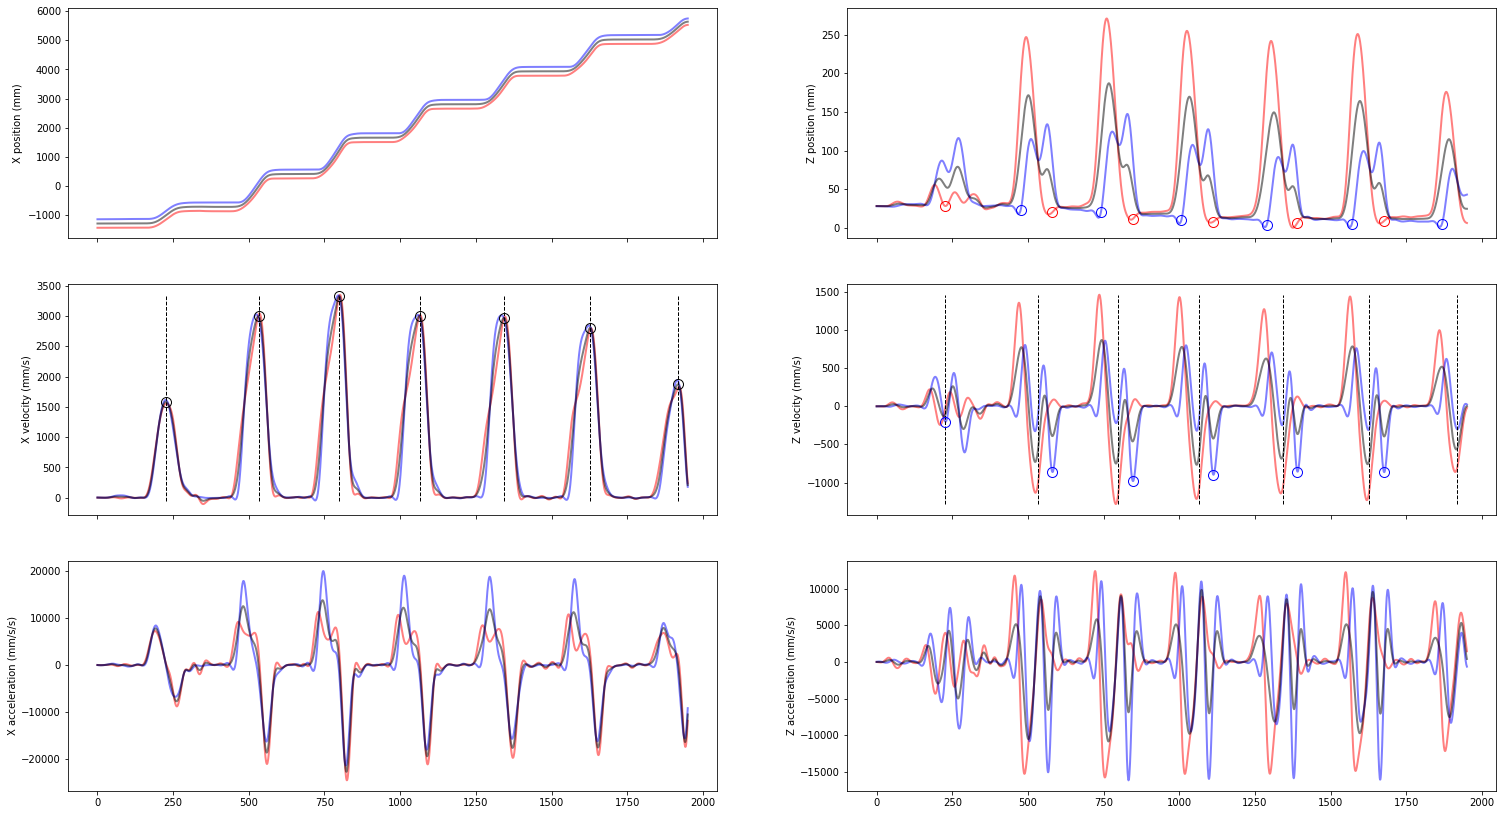

In [15]:
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(25.6, 14.4))

# Position data
axs[0][0].plot(np.arange(r_heel_pos.shape[0]), r_heel_pos[:,0], '-', c=(1, 0, 0, 0.5), lw=2)
axs[0][0].plot(np.arange(r_toe_pos.shape[0]), r_toe_pos[:,0], '-', c=(0, 0, 1, 0.5), lw=2)
axs[0][0].plot(np.arange(r_mid_foot_pos.shape[0]), r_mid_foot_pos[:,0], '-', c=(0, 0, 0, 0.5), lw=2)
axs[0][1].plot(np.arange(r_heel_pos.shape[0]), r_heel_pos[:,2], '-', c=(1, 0, 0, 0.5), lw=2)
axs[0][1].plot(np.arange(r_toe_pos.shape[0]), r_toe_pos[:,2], '-', c=(0, 0, 1, 0.5), lw=2)
axs[0][1].plot(np.arange(r_mid_foot_pos.shape[0]), r_mid_foot_pos[:,2], '-', c=(0, 0, 0, 0.5), lw=2)
axs[0][0].set_ylabel('X position (mm)')
axs[0][1].set_ylabel('Z position (mm)')

# Velocity
axs[1][0].plot(np.arange(r_heel_vel.shape[0]), r_heel_vel[:,0], '-', c=(1, 0, 0, 0.5), lw=2)
axs[1][0].plot(np.arange(r_toe_vel.shape[0]), r_toe_vel[:,0], '-', c=(0, 0, 1, 0.5), lw=2)
axs[1][0].plot(np.arange(r_mid_foot_vel.shape[0]), r_mid_foot_vel[:,0], '-', c=(0, 0, 0, 0.5), lw=2)
axs[1][0].plot(ix_max_vel_x, r_mid_foot_vel[ix_max_vel_x,0], 'o', mfc='none', mec=(0, 0, 0, 1), ms=10)
axs[1][1].plot(np.arange(r_heel_vel.shape[0]), r_heel_vel[:,2], '-', c=(1, 0, 0, 0.5), lw=2)
axs[1][1].plot(np.arange(r_toe_vel.shape[0]), r_toe_vel[:,2], '-', c=(0, 0, 1, 0.5), lw=2)
axs[1][1].plot(np.arange(r_mid_foot_vel.shape[0]), r_mid_foot_vel[:,2], '-', c=(0, 0, 0, 0.5), lw=2)
axs[1][0].set_ylabel('X velocity (mm/s)')
axs[1][1].set_ylabel('Z velocity (mm/s)')

# Acceleration
axs[2][0].plot(np.arange(r_heel_acc.shape[0]), r_heel_acc[:,0], '-', c=(1, 0, 0, 0.5), lw=2)
axs[2][0].plot(np.arange(r_toe_acc.shape[0]), r_toe_acc[:,0], '-', c=(0, 0, 1, 0.5), lw=2)
axs[2][0].plot(np.arange(r_mid_foot_acc.shape[0]), r_mid_foot_acc[:,0], '-', c=(0, 0, 0, 0.5), lw=2)
axs[2][1].plot(np.arange(r_heel_acc.shape[0]), r_heel_acc[:,2], '-', c=(1, 0, 0, 0.5), lw=2)
axs[2][1].plot(np.arange(r_toe_acc.shape[0]), r_toe_acc[:,2], '-', c=(0, 0, 1, 0.5), lw=2)
axs[2][1].plot(np.arange(r_mid_foot_acc.shape[0]), r_mid_foot_acc[:,2], '-', c=(0, 0, 0, 0.5), lw=2)
axs[2][0].set_ylabel('X acceleration (mm/s/s)')
axs[2][1].set_ylabel('Z acceleration (mm/s/s)')

# Peaks
for i in ix_max_vel_x:
    axs[1][0].plot([i, i], [np.min(r_mid_foot_vel[:,0]), np.max(r_mid_foot_vel[:,0])], '--', c=(0, 0, 0), lw=1)
    axs[1][1].plot([i, i], [np.min(r_heel_vel[:,2]), np.max(r_heel_vel[:,2])], '--', c=(0, 0, 0), lw=1)
axs[0][1].plot(r_ix_FC, r_toe_pos[r_ix_FC,2], 'o', mfc='none', mec=(0, 0, 1), ms=10)
axs[0][1].plot(r_ix_IC_2, r_heel_pos[r_ix_IC_2,2], 'o', mfc='none', mec=(1, 0, 0), ms=10)
axs[1][1].plot(r_ix_IC_2, r_toe_vel[r_ix_IC_2,2], 'o', mfc='none', mec=(0, 0, 1), ms=10)

plt.show()

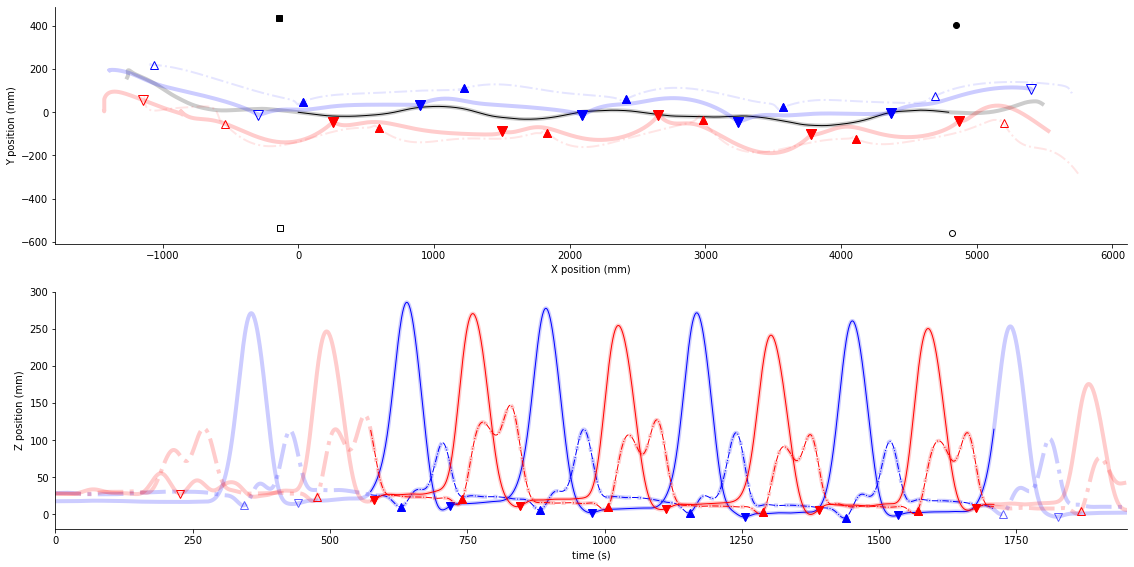

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(19.2, 9.6))
# Top view
# -- Start and end cones
axs[0].plot(np.mean(start_1[:,0]), np.mean(start_1[:,1]), 'o', mfc='none', mec=(0, 0, 0, 1), ms=6)
axs[0].plot(np.mean(start_2[:,0]), np.mean(start_2[:,1]), 'o', mfc=(0, 0, 0, 1), mec=(0, 0, 0, 1), ms=6)
axs[0].plot(np.mean(end_1[:,0]), np.mean(end_1[:,1]), 's', mfc='none', mec=(0, 0, 0, 1), ms=6)
axs[0].plot(np.mean(end_2[:,0]), np.mean(end_2[:,1]), 's', mfc=(0, 0, 0, 1), mec=(0, 0, 0, 1), ms=6)
# -- Virtual pelvis marker
axs[0].plot(pelvis_pos[:,0], pelvis_pos[:,1], '-', c=(0, 0, 0, 0.2), lw=4)
axs[0].plot(pelvis_pos[ix_start:ix_end,0], pelvis_pos[ix_start:ix_end,1], '-', c=(0, 0, 0, 1), lw=1)
# -- Left heel/toe marker
axs[0].plot(l_heel_pos[:,0], l_heel_pos[:,1], '-', c=(0, 0, 1, 0.2), lw=4)
axs[0].plot(l_heel_pos[l_ix_IC_2,0], l_heel_pos[l_ix_IC_2,1], 'v', mfc='none', mec=(0, 0, 1, 1), ms=10)
axs[0].plot(l_heel_pos[left_ix_IC_2,0], l_heel_pos[left_ix_IC_2,1], 'v', mfc=(0, 0, 1, 1), mec=(0, 0, 1, 1), ms=10)
axs[0].plot(l_toe_pos[:,0], l_toe_pos[:,1], '-.', c=(0, 0, 1, 0.1), lw=2)
axs[0].plot(l_toe_pos[l_ix_FC,0], l_toe_pos[l_ix_FC,1], '^', mfc='none', mec=(0, 0, 1, 1), ms=8)
axs[0].plot(l_toe_pos[left_ix_FC,0], l_toe_pos[left_ix_FC,1], '^', mfc=(0, 0, 1, 1), mec=(0, 0, 1, 1), ms=8)
# -- Right heel marker
axs[0].plot(r_heel_pos[:,0], r_heel_pos[:,1], '-', c=(1, 0, 0, 0.2), lw=4)
axs[0].plot(r_heel_pos[r_ix_IC_2,0], r_heel_pos[r_ix_IC_2,1], 'v', mfc='none', mec=(1, 0, 0, 1), ms=10)
axs[0].plot(r_heel_pos[right_ix_IC_2,0], r_heel_pos[right_ix_IC_2,1], 'v', mfc=(1, 0, 0, 1), mec=(1, 0, 0, 1), ms=10)
axs[0].plot(r_toe_pos[:,0], r_toe_pos[:,1], '-.', c=(1, 0, 0, 0.1), lw=2)
axs[0].plot(r_toe_pos[r_ix_FC,0], r_toe_pos[r_ix_FC,1], '^', mfc='none', mec=(1, 0, 0, 1), ms=8)
axs[0].plot(r_toe_pos[right_ix_FC,0], r_toe_pos[right_ix_FC,1], '^', mfc=(1, 0, 0, 1), mec=(1, 0, 0, 1), ms=8)
axs[0].set_xlabel('X position (mm)')
axs[0].set_ylabel('Y position (mm)')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

# Sagittal view
# -- Left heel/toe marker
axs[1].plot(np.arange(aligned_data.shape[0]), l_heel_pos[:,2], '-', c=(0, 0, 1, 0.2), lw=4)
axs[1].plot(np.arange(ix_start, ix_end), l_heel_pos[ix_start:ix_end,2], '-', c=(0, 0, 1, 1), lw=1)
axs[1].plot(l_ix_IC_2, l_heel_pos[l_ix_IC_2,2], 'v', mfc='none', mec=(0, 0, 1, 0.6), ms=8)
axs[1].plot(left_ix_IC_2, l_heel_pos[left_ix_IC_2,2], 'v', mfc=(0, 0, 1, 1), mec=(0, 0, 1, 1), ms=8)
axs[1].plot(np.arange(aligned_data.shape[0]), l_toe_pos[:,2], '-.', c=(0, 0, 1, 0.2), lw=4)
axs[1].plot(np.arange(ix_start, ix_end), l_toe_pos[ix_start:ix_end,2], '-.', c=(0, 0, 1, 1), lw=1)
axs[1].plot(l_ix_FC, l_toe_pos[l_ix_FC,2], '^', mfc='none', mec=(0, 0, 1, 0.6), ms=8)
axs[1].plot(left_ix_FC, l_toe_pos[left_ix_FC,2], '^', mfc=(0, 0, 1, 1), mec=(0, 0, 1, 1), ms=8)
# -- Right heel/toe marker
axs[1].plot(np.arange(aligned_data.shape[0]), r_heel_pos[:,2], '-', c=(1, 0, 0, 0.2), lw=4)
axs[1].plot(np.arange(ix_start, ix_end), r_heel_pos[ix_start:ix_end,2], '-', c=(1, 0, 0, 1), lw=1)
axs[1].plot(r_ix_IC_2, r_heel_pos[r_ix_IC_2,2], 'v', mfc='none', mec=(1, 0, 0, 1), ms=8)
axs[1].plot(right_ix_IC_2, r_heel_pos[right_ix_IC_2,2], 'v', mfc=(1, 0, 0, 1), mec=(1, 0, 0, 1), ms=8)
axs[1].plot(np.arange(aligned_data.shape[0]), r_toe_pos[:,2], '-.', c=(1, 0, 0, 0.2), lw=4)
axs[1].plot(np.arange(ix_start, ix_end), r_toe_pos[ix_start:ix_end,2], '-.', c=(1, 0, 0, 1), lw=1)
axs[1].plot(r_ix_FC, r_toe_pos[r_ix_FC,2], '^', mfc='none', mec=(1, 0, 0, 1), ms=8)
axs[1].plot(right_ix_FC, r_toe_pos[right_ix_FC,2], '^', mfc=(1, 0, 0, 1), mec=(1, 0, 0, 1), ms=8)
axs[1].set_xlim(0, aligned_data.shape[0])
axs[1].set_xlabel('time (s)')
axs[1].set_ylabel('Z position (mm)')
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
plt.show()

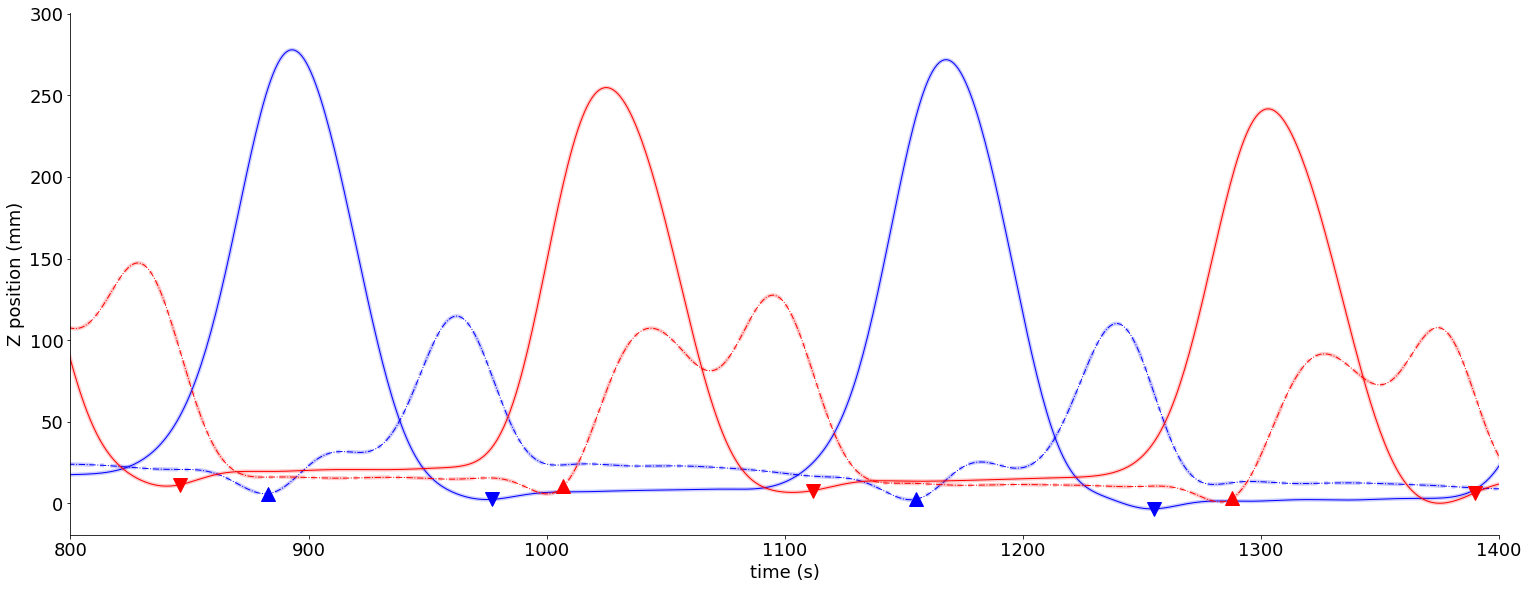

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(25.6, 9.6))
# -- Left heel/toe marker
axs.plot(np.arange(aligned_data.shape[0]), l_heel_pos[:,2], '-', c=(0, 0, 1, 0.2), lw=4)
axs.plot(np.arange(ix_start, ix_end), l_heel_pos[ix_start:ix_end,2], '-', c=(0, 0, 1, 1), lw=1)
axs.plot(l_ix_IC_2, l_heel_pos[l_ix_IC_2,2], 'v', mfc='none', mec=(0, 0, 1, 0.6), ms=8)
axs.plot(left_ix_IC_2, l_heel_pos[left_ix_IC_2,2], 'v', mfc=(0, 0, 1, 1), mec=(0, 0, 1, 1), ms=14)
axs.plot(np.arange(aligned_data.shape[0]), l_toe_pos[:,2], '-.', c=(0, 0, 1, 0.2), lw=4)
axs.plot(np.arange(ix_start, ix_end), l_toe_pos[ix_start:ix_end,2], '-.', c=(0, 0, 1, 1), lw=1)
axs.plot(l_ix_FC, l_toe_pos[l_ix_FC,2], '^', mfc='none', mec=(0, 0, 1, 0.6), ms=8)
axs.plot(left_ix_FC, l_toe_pos[left_ix_FC,2], '^', mfc=(0, 0, 1, 1), mec=(0, 0, 1, 1), ms=14)
# -- Right heel/toe marker
axs.plot(np.arange(aligned_data.shape[0]), r_heel_pos[:,2], '-', c=(1, 0, 0, 0.2), lw=4)
axs.plot(np.arange(ix_start, ix_end), r_heel_pos[ix_start:ix_end,2], '-', c=(1, 0, 0, 1), lw=1)
axs.plot(r_ix_IC_2, r_heel_pos[r_ix_IC_2,2], 'v', mfc='none', mec=(1, 0, 0, 1), ms=8)
axs.plot(right_ix_IC_2, r_heel_pos[right_ix_IC_2,2], 'v', mfc=(1, 0, 0, 1), mec=(1, 0, 0, 1), ms=14)
axs.plot(np.arange(aligned_data.shape[0]), r_toe_pos[:,2], '-.', c=(1, 0, 0, 0.2), lw=4)
axs.plot(np.arange(ix_start, ix_end), r_toe_pos[ix_start:ix_end,2], '-.', c=(1, 0, 0, 1), lw=1)
axs.plot(r_ix_FC, r_toe_pos[r_ix_FC,2], '^', mfc='none', mec=(1, 0, 0, 1), ms=8)
axs.plot(right_ix_FC, r_toe_pos[right_ix_FC,2], '^', mfc=(1, 0, 0, 1), mec=(1, 0, 0, 1), ms=14)
# axs.set_xlim(0, aligned_data.shape[0])
axs.set_xlim(800, 1400)
axs.set_xlabel('time (s)', fontsize=18)
axs.set_ylabel('Z position (mm)', fontsize=18)
axs.tick_params(axis="x", labelsize=18)
axs.tick_params(axis="y", labelsize=18)
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
plt.show()

## 4. Process the data - extract temporal gait parameters
We use the detected instances of IC and FC to extract relevant temporal gait parameters:
- left/right stride time: the time between two successive ICs of the same limb
- left/right swing time: the time between the FC and following IC of the same limb
- left/right stance time: the time between each IC and the following FC of the same limb
- double limb support time: the time between each IC and the following FC of the contralateral limb

In [18]:
out = _extract_temporal_gait_params(left_ix_IC_2, left_ix_FC, right_ix_IC_2, right_ix_FC, fs_omc)
print(out)

{'left_stride_time': array([1.29 , 1.39 , 1.395]), 'left_stance_time': array([0.82, 0.89, 0.92]), 'left_swing_time': array([0.47 , 0.5  , 0.475]), 'right_stride_time': array([1.33, 1.33, 1.39, 1.43]), 'right_stance_time': array([0.805, 0.805, 0.88 , 0.9  ]), 'right_swing_time': array([0.525, 0.525, 0.51 , 0.53 ]), 'double_limb_support_time': array([0.355, 0.335, 0.38 , 0.425]), 'single_limb_support_time': array([0.975, 0.995, 1.01 , 1.005])}


## 5. References

- Bruening, D. A., & Ridge, S. T. (2014). Automated event detection algorithms in pathological gait. Gait & posture, 39(1), 472–477. <a href="https://doi.org/10.1016/j.gaitpost.2013.08.023">https://doi.org/10.1016/j.gaitpost.2013.08.023</a>
- Hendershot, B. D., Mahon, C. E., & Pruziner, A. L. (2016). A comparison of kinematic-based gait event detection methods in a self-paced treadmill application. Journal of biomechanics, 49(16), 4146–4149. <a href="https://doi.org/10.1016/j.jbiomech.2016.10.046">https://doi.org/10.1016/j.jbiomech.2016.10.046</a>
- O'Connor, C. M., Thorpe, S. K., O'Malley, M. J., & Vaughan, C. L. (2007). Automatic detection of gait events using kinematic data. Gait & posture, 25(3), 469–474. <a href="https://doi.org/10.1016/j.gaitpost.2006.05.016">https://doi.org/10.1016/j.gaitpost.2006.05.016</a>
- Pijnappels, M., Bobbert, M. F., & van Dieën, J. H. (2001). Changes in walking pattern caused by the possibility of a tripping reaction. Gait & posture, 14(1), 11–18. <a href="https://doi.org/10.1016/s0966-6362(01)00110-2">https://doi.org/10.1016/s0966-6362(01)00110-2</a>
- Rueterbories, J., Spaich, E. G., Larsen, B., & Andersen, O. K. (2010). Methods for gait event detection and analysis in ambulatory systems. Medical engineering & physics, 32(6), 545–552. <a href="https://doi.org/10.1016/j.medengphy.2010.03.007">https://doi.org/10.1016/j.medengphy.2010.03.007</a>
- Ulrich, B., Santos, A. N., Jolles, B. M., Benninger, D. H., & Favre, J. (2019). Gait events during turning can be detected using kinematic features originally proposed for the analysis of straight-line walking. Journal of biomechanics, 91, 69–78. <a href="https://doi.org/10.1016/j.jbiomech.2019.05.006">https://doi.org/10.1016/j.jbiomech.2019.05.006</a>
- Zeni, J. A., Jr, Richards, J. G., & Higginson, J. S. (2008). Two simple methods for determining gait events during treadmill and overground walking using kinematic data. Gait & posture, 27(4), 710–714. <a href="https://doi.org/10.1016/j.gaitpost.2007.07.007">https://doi.org/10.1016/j.gaitpost.2007.07.007</a>


## 6. Process the IMU data
Now, use a similar approach to get the IMU data.

In [19]:
imu_labels = imu_data["imu_location"]
print(imu_labels)

['head' 'sternum' 'left_upper_arm' 'left_fore_arm' 'right_upper_arm'
 'right_fore_arm' 'pelvis' 'left_thigh' 'left_shank' 'left_foot'
 'right_thigh' 'right_shank' 'right_foot' 'left_ankle' 'right_ankle'
 'pocket']


In [20]:
l_ank_gyro_init = imu_data["gyro"][:,:,np.argwhere(imu_data["imu_location"]=="left_ankle")[:,0][0]]
l_ank_acc_init  = imu_data["acc"][:,:,np.argwhere(imu_data["imu_location"]=="left_ankle")[:,0][0]]
r_ank_gyro_init = imu_data["gyro"][:,:,np.argwhere(imu_data["imu_location"]=="right_ankle")[:,0][0]]
r_ank_acc_init  = imu_data["acc"][:,:,np.argwhere(imu_data["imu_location"]=="right_ankle")[:,0][0]]

In [21]:
l_ank_acc, l_ank_gyro, l_ix_MS_IMU, l_ix_IC_IMU, l_ix_FC_IMU = _get_gait_evens_from_IMU(imu_data, label="left_ankle")
r_ank_acc, r_ank_gyro, r_ix_MS_IMU, r_ix_IC_IMU, r_ix_FC_IMU = _get_gait_evens_from_IMU(imu_data, label="right_ankle")

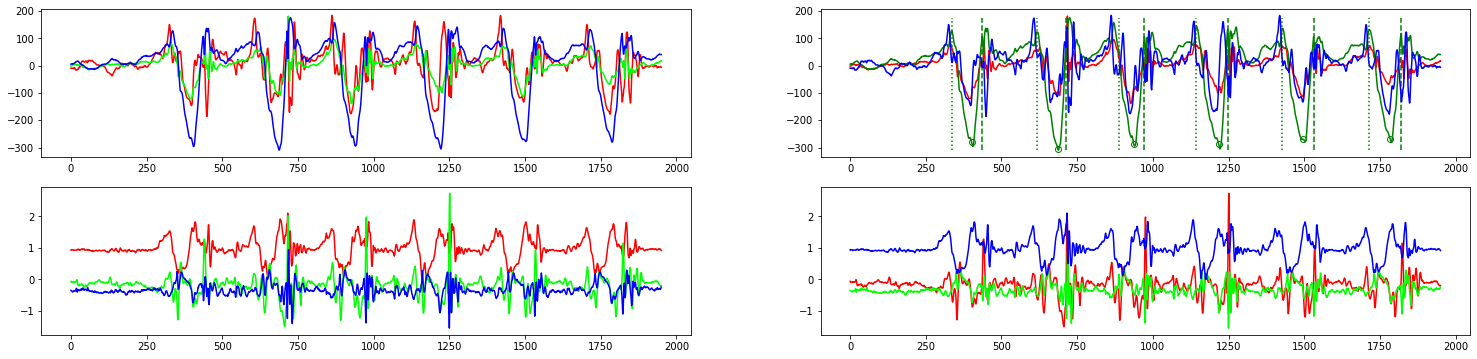

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(25.6, 6.))
ax[0][0].plot(l_ank_gyro_init[:,0], c=(1, 0, 0))
ax[0][0].plot(l_ank_gyro_init[:,1], c=(0, 1, 0))
ax[0][0].plot(l_ank_gyro_init[:,2], c=(0, 0, 1))
ax[1][0].plot(l_ank_acc_init[:,0], c=(1, 0, 0))
ax[1][0].plot(l_ank_acc_init[:,1], c=(0, 1, 0))
ax[1][0].plot(l_ank_acc_init[:,2], c=(0, 0, 1))

ax[0][1].plot(l_ank_gyro[:,0], ls='-', c=(1, 0, 0))
ax[0][1].plot(l_ank_gyro[:,1], ls='-', c=(0, 0.5, 0))
ax[0][1].plot(l_ix_MS_IMU, l_ank_gyro[l_ix_MS_IMU,1], 'o', mfc='none', mec=(0, 0.5, 0))
for i in range(len(l_ix_IC_IMU)):
    ax[0][1].plot([l_ix_IC_IMU[i], l_ix_IC_IMU[i]], [np.min(l_ank_gyro[:,1]), np.max(l_ank_gyro[:,1])], '--', c=(0, 0.5, 0))
for i in range(len(l_ix_FC_IMU)):
    ax[0][1].plot([l_ix_FC_IMU[i], l_ix_FC_IMU[i]], [np.min(l_ank_gyro[:,1]), np.max(l_ank_gyro[:,1])], ':', c=(0, 0.5, 0))
ax[0][1].plot(l_ank_gyro[:,2], ls='-', c=(0, 0, 1))
ax[1][1].plot(l_ank_acc[:,0], ls='-', c=(1, 0, 0))
ax[1][1].plot(l_ank_acc[:,1], ls='-', c=(0, 1, 0))
ax[1][1].plot(l_ank_acc[:,2], ls='-', c=(0, 0, 1))

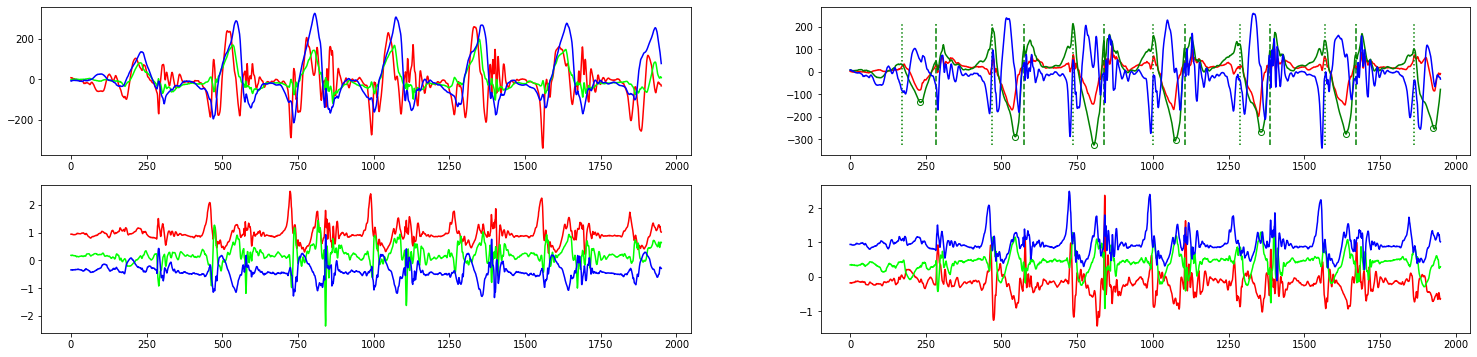

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(25.6, 6.))
ax[0][0].plot(r_ank_gyro_init[:,0], c=(1, 0, 0))
ax[0][0].plot(r_ank_gyro_init[:,1], c=(0, 1, 0))
ax[0][0].plot(r_ank_gyro_init[:,2], c=(0, 0, 1))
ax[1][0].plot(r_ank_acc_init[:,0], c=(1, 0, 0))
ax[1][0].plot(r_ank_acc_init[:,1], c=(0, 1, 0))
ax[1][0].plot(r_ank_acc_init[:,2], c=(0, 0, 1))

ax[0][1].plot(r_ank_gyro[:,0], ls='-', c=(1, 0, 0))
ax[0][1].plot(r_ank_gyro[:,1], ls='-', c=(0, 0.5, 0))
ax[0][1].plot(r_ix_MS_IMU, r_ank_gyro[r_ix_MS_IMU,1], 'o', mfc='none', mec=(0, 0.5, 0))
for i in range(len(r_ix_IC_IMU)):
    ax[0][1].plot([r_ix_IC_IMU[i], r_ix_IC_IMU[i]], [np.min(r_ank_gyro[:,1]), np.max(r_ank_gyro[:,1])], '--', c=(0, 0.5, 0))
for i in range(len(r_ix_FC_IMU)):
    ax[0][1].plot([r_ix_FC_IMU[i], r_ix_FC_IMU[i]], [np.min(r_ank_gyro[:,1]), np.max(r_ank_gyro[:,1])], ':', c=(0, 0.5, 0))
ax[0][1].plot(r_ank_gyro[:,2], ls='-', c=(0, 0, 1))
ax[1][1].plot(r_ank_acc[:,0], ls='-', c=(1, 0, 0))
ax[1][1].plot(r_ank_acc[:,1], ls='-', c=(0, 1, 0))
ax[1][1].plot(r_ank_acc[:,2], ls='-', c=(0, 0, 1))

## 7. Evaluate
Compare the findings from the IMU to the reference timings from the optical motion capture system.

In [24]:
# Only evaluate for the events registered within the 5 meter distance
# left_ix_IC = l_ix_IC[np.logical_and(l_ix_IC >= ix_start, l_ix_IC <= ix_end)]
left_ix_IC_IMU = l_ix_IC_IMU[np.logical_and(l_ix_IC_IMU >= ix_start, l_ix_IC_IMU <= ix_end)]
left_ix_FC_IMU = l_ix_FC_IMU[np.logical_and(l_ix_FC_IMU >= ix_start, l_ix_FC_IMU <= ix_end)]
right_ix_IC_IMU = r_ix_IC_IMU[np.logical_and(r_ix_IC_IMU >= ix_start, r_ix_IC_IMU <= ix_end)]
right_ix_FC_IMU = r_ix_FC_IMU[np.logical_and(r_ix_FC_IMU >= ix_start, r_ix_FC_IMU <= ix_end)]


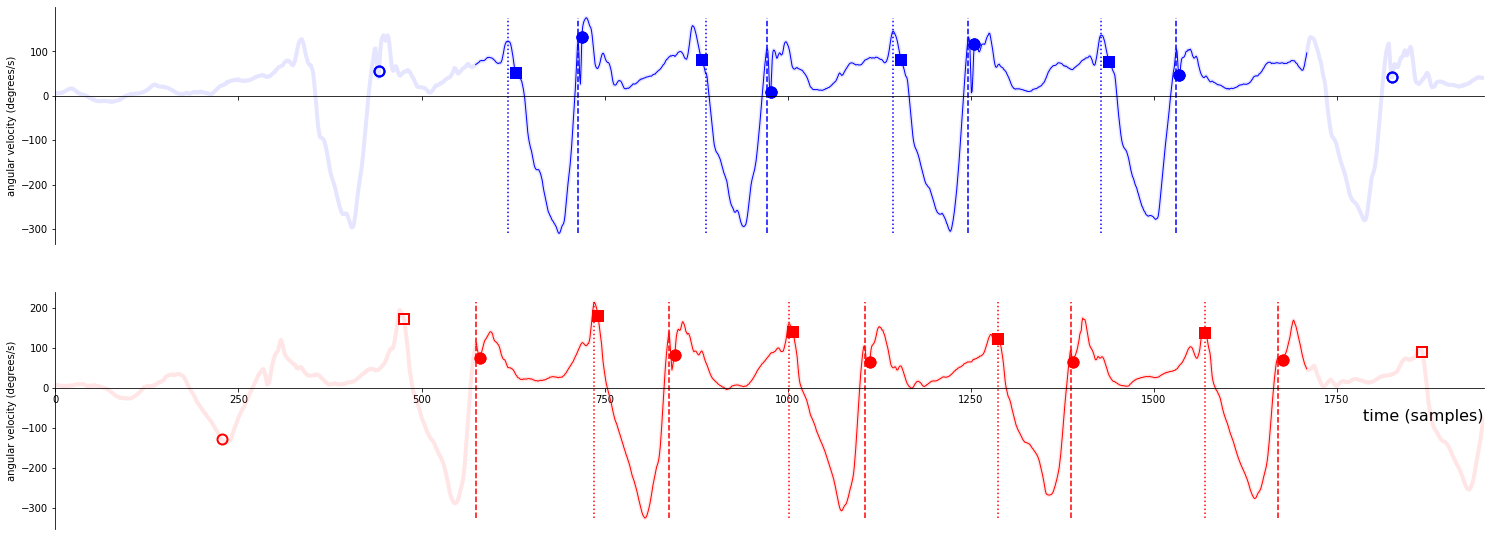

In [31]:
figure, axs = plt.subplots(2, 1, figsize=(25.6, 9.6), sharex=True)

# ----- Left side ---------------
axs[0].plot(np.arange(l_ank_gyro.shape[0]), l_ank_gyro[:,1], '-', c=(0, 0, 1, 0.1), lw=4)
axs[0].plot(np.arange(ix_start, ix_end), l_ank_gyro[ix_start:ix_end,1], '-', c=(0, 0, 1), lw=1)
axs[0].plot(left_ix_IC_2, l_ank_gyro[left_ix_IC_2,1], 'o', mfc=(0, 0, 1), mec=(0, 0, 1), mew=2, ms=10)
axs[0].plot(l_ix_IC_2, l_ank_gyro[l_ix_IC_2,1], 'o', mfc='none', mec=(0, 0, 1), mew=2, ms=10)
for i in range(len(left_ix_IC_IMU)):
    axs[0].plot([left_ix_IC_IMU[i], left_ix_IC_IMU[i]], [np.min(l_ank_gyro[:,1]), np.max(l_ank_gyro[:,1])], '--', c=(0, 0, 1))
axs[0].plot(left_ix_FC, l_ank_gyro[left_ix_FC,1], 's', mfc=(0, 0, 1), mec=(0, 0, 1), mew=2, ms=10)
axs[0].plot(l_ix_IC_2, l_ank_gyro[l_ix_IC_2,1], 'o', mfc='none', mec=(0, 0, 1), mew=2, ms=10)
for i in range(len(left_ix_FC_IMU)):
    axs[0].plot([left_ix_FC_IMU[i], left_ix_FC_IMU[i]], [np.min(l_ank_gyro[:,1]), np.max(l_ank_gyro[:,1])], ':', c=(0, 0, 1))

# ----- Right side ----------
axs[1].plot(np.arange(r_ank_gyro.shape[0]), r_ank_gyro[:,1], '-', c=(1, 0, 0, 0.1), lw=4)
axs[1].plot(np.arange(ix_start, ix_end), r_ank_gyro[ix_start:ix_end,1], '-', c=(1, 0, 0), lw=1)
axs[1].plot(r_ix_IC_2, r_ank_gyro[r_ix_IC_2,1], 'o', mfc='none', mec=(1, 0, 0), mew=2, ms=10)
axs[1].plot(right_ix_IC_2, r_ank_gyro[right_ix_IC_2,1], 'o', mfc=(1, 0, 0), mec=(1, 0, 0), mew=2, ms=10)
for i in range(len(right_ix_IC_IMU)):
    axs[1].plot([right_ix_IC_IMU[i], right_ix_IC_IMU[i]], [np.min(r_ank_gyro[:,1]), np.max(r_ank_gyro[:,1])], '--', c=(1, 0, 0))
axs[1].plot(right_ix_FC, r_ank_gyro[right_ix_FC,1], 's', mfc=(1, 0, 0), mec=(1, 0, 0), mew=2, ms=10)
axs[1].plot(r_ix_FC, r_ank_gyro[r_ix_FC,1], 's', mfc='none', mec=(1, 0, 0), mew=2, ms=10)
for i in range(len(right_ix_FC_IMU)):
    axs[1].plot([right_ix_FC_IMU[i], right_ix_FC_IMU[i]], [np.min(r_ank_gyro[:,1]), np.max(r_ank_gyro[:,1])], ':', c=(1, 0, 0))

axs[0].set_ylabel(f'angular velocity (degrees/s)')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_position('zero')
axs[1].set_ylabel(f'angular velocity (degrees/s)')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_position('zero')
axs[1].set_xlabel(f'time (samples)', loc='right', fontsize=16)
axs[1].set_xlim(0, r_ank_gyro.shape[0])
plt.show()

In [27]:
ref = _extract_temporal_gait_params(left_ix_IC_2, left_ix_FC, right_ix_IC_2, right_ix_FC, fs_omc)
pred = _extract_temporal_gait_params(left_ix_IC_IMU, left_ix_FC_IMU, right_ix_IC_IMU, right_ix_FC_IMU, fs_imu)

In [28]:
ref

{'left_stride_time': array([1.29 , 1.39 , 1.395]),
 'left_stance_time': array([0.82, 0.89, 0.92]),
 'left_swing_time': array([0.47 , 0.5  , 0.475]),
 'right_stride_time': array([1.33, 1.33, 1.39, 1.43]),
 'right_stance_time': array([0.805, 0.805, 0.88 , 0.9  ]),
 'right_swing_time': array([0.525, 0.525, 0.51 , 0.53 ]),
 'double_limb_support_time': array([0.355, 0.335, 0.38 , 0.425]),
 'single_limb_support_time': array([0.975, 0.995, 1.01 , 1.005])}

In [29]:
pred

{'left_stride_time': array([1.29 , 1.375, 1.42 ]),
 'left_stance_time': array([0.875, 0.86 , 0.905]),
 'left_swing_time': array([0.415, 0.515, 0.515]),
 'right_stride_time': array([1.315, 1.335, 1.41 , 1.415]),
 'right_stance_time': array([0.805, 0.82 , 0.91 , 0.915]),
 'right_swing_time': array([0.51 , 0.515, 0.5  , 0.5  ]),
 'double_limb_support_time': array([0.325, 0.405, 0.395, 0.4  ]),
 'single_limb_support_time': array([0.99 , 0.93 , 1.015, 1.015])}